In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import functional as F
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

## Using spatial features reasoning in semisupervised learning

In [2]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
])
trainset = torchvision.datasets.MNIST(root='./data', transform=transform, train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', transform=transform, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                        shuffle=False, num_workers=2)
trainset[0][0].shape

torch.Size([1, 28, 28])

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = []
        for i in range(6000):
            self.dataset.append((torch.rand((1, 28, 28)), 10))
        for i in range(len(trainset)):
            self.dataset.append(trainset[i])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

traindata = Dataset()

In [4]:
batch_size = 64

In [5]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True)

In [6]:
class ON(nn.Module):
    def __init__(self):
        super(ON, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 2)
        self.conv3 = nn.Conv2d(32, 32, 5, 1)
        self.flat = nn.Flatten()
        self.relu = F.relu
        self.fc1 = nn.Linear(2048, 1024)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        return x
    
class RN(nn.Module):
    def __init__(self):
        super(RN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        return x
    
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.classif = ON()
        self.discrim = RN()
        self.fc = nn.Linear(1280, 512)
        self.fcc = nn.Linear(512, 11)
        
    def forward(self, x):
        o1 = self.classif(x)
        o2 = self.discrim(x)
        x = torch.cat((o1, o2), 1)
        x = x.to(device)
        x = self.fc(x)
        x = F.relu(self.fcc(x))
        return x
    
model = NN()

In [7]:
device = torch.device("cuda:0")
model.to(device)

NN(
  (classif): ON(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (flat): Flatten()
    (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  )
  (discrim): RN(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
  )
  (fc): Linear(in_features=1280, out_features=512, bias=True)
  (fcc): Linear(in_features=512, out_features=11, bias=True)
)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [10]:
running_loss_i = []
running_loss_e = []

for i in range(10):
    total_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device); labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss_i.append(loss.item())
        total_loss += loss.item()
        
    running_loss_e.append(total_loss/len(trainloader))
    print("Epoch elapsed loss is {}".format(total_loss/len(trainloader)))

Epoch elapsed loss is 1.0407235994646253
Epoch elapsed loss is 0.5391231555953737
Epoch elapsed loss is 0.4738184461846601
Epoch elapsed loss is 0.4191974955069464
Epoch elapsed loss is 0.3796405747330697
Epoch elapsed loss is 0.35319751662079446
Epoch elapsed loss is 0.3351145379981676
Epoch elapsed loss is 0.3219764633609574
Epoch elapsed loss is 0.3129113948932856
Epoch elapsed loss is 0.3052979503982058


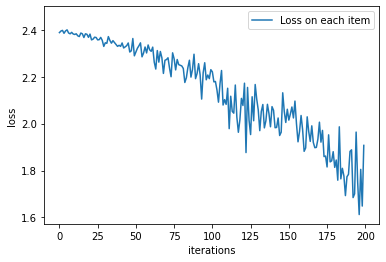

In [11]:
plt.plot(np.arange(len(running_loss_i[:200])), running_loss_i[:200], label='Loss on each item')
plt.legend()
plt.ylabel("loss")
plt.ylim(ymax=2.5)
plt.xlabel("iterations")
plt.savefig("Loss per iteration_spatial.png")

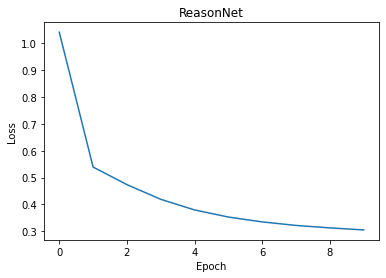

In [12]:
plt.plot(np.arange(len(running_loss_e)), running_loss_e, label='Loss after each epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title('ReasonNet')
plt.savefig('reasonet.jpg')
plt.savefig("Loss per epoch spatial.png")

In [13]:
class Testdataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = []
        for i in range(1000):
            self.dataset.append((torch.rand((1, 28, 28)), 10))
        for i in range(len(testset)):
            self.dataset.append(testset[i])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

testdata = Testdataset()
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=False)
model.eval()
loss_on_test = 0
for images, labels in testloader:
    images = images.to(device); labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_on_test += loss.item()
print("Final loss {}".format(loss_on_test/len(testloader)))

Final loss 0.30255822681410366


In [14]:
torch.save(model.state_dict(), 'net.pth')

## Building a supervised reasoning network

In [2]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
])

trainset = torchvision.datasets.MNIST(root='./data', transform=transform, train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', transform=transform, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [3]:
class VN(nn.Module):
    def __init__(self):
        super(VN, self).__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(784, 256, bias=False)
        self.fc2 = nn.Linear(256, 10, bias=False)
        
    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    def get_weights(self, i):
        return self.fc2.weight[i]
#get weight 256, 0 -> reasoning for 0. weight 256, 1 -> reasoning for 1 and so on

In [4]:
class Reasonable(nn.Module):
    def __init__(self):
        super(Reasonable, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 2)
        self.conv3 = nn.Conv2d(32, 32, 5, 1)
        self.flat = nn.Flatten()
        self.relu = F.relu
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
#For reasoning net input -> image output->reason vector loss MSE

In [5]:
device = torch.device("cuda:0")

### 10 epochs

In [6]:
model_VN = VN()
model_VN.to(device)

VN(
  (flat): Flatten()
  (fc1): Linear(in_features=784, out_features=256, bias=False)
  (fc2): Linear(in_features=256, out_features=10, bias=False)
)

In [7]:
model_Reasonable = Reasonable()
model_Reasonable.to(device)

Reasonable(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
)

In [8]:
optimizer_VN = optim.Adam(model_VN.parameters(), lr=1e-5)
criterion_VN = nn.CrossEntropyLoss()
running_loss_i_VN = []
running_loss_e_VN = []

optimizer_Reasonable = optim.Adam(model_Reasonable.parameters(), lr=1e-5)
criterion_Reasonable = nn.MSELoss()
running_loss_i_Reasonable = []
running_loss_e_Reasonable = []

for i in range(10):
    total_loss_VN = 0
    total_loss_Reasonable = 0
    
    for images, labels in trainloader:
        images = images.to(device); labels = labels.to(device)
        
        optimizer_VN.zero_grad()
        outputs_VN = model_VN(images)
        loss_VN = criterion_VN(outputs_VN, labels)
        loss_VN.backward()
        optimizer_VN.step()
        
        running_loss_i_VN.append(loss_VN.item())
        total_loss_VN += loss_VN.item()
        
        labels_Reasonable = []
        for label in labels:
            labels_Reasonable.append(model_VN.get_weights(label))

        labels = torch.stack(labels_Reasonable)
        
        optimizer_Reasonable.zero_grad()
        outputs_Reasonable = model_Reasonable(images)
        loss_Reasonable = criterion_Reasonable(outputs_Reasonable, labels)
        loss_Reasonable.backward()
        optimizer_Reasonable.step()
        
        running_loss_i_Reasonable.append(loss_Reasonable.item())
        total_loss_Reasonable += loss_Reasonable.item()

    running_loss_e_VN.append(total_loss_VN/len(trainloader))
    running_loss_e_Reasonable.append(total_loss_Reasonable/len(trainloader))
    
    print("Epoch {}:".format(i))
    print("    VN loss: {}".format(total_loss_VN/len(trainloader)))
    print("    Reasonable loss: {}\n".format(total_loss_Reasonable/len(trainloader)))

Epoch 0:
    VN loss: 1.2974453901608785
    Reasonable loss: 0.0005424054777792965

Epoch 1:
    VN loss: 0.615260392109553
    Reasonable loss: 0.0003171635933375607

Epoch 2:
    VN loss: 0.4631588597218196
    Reasonable loss: 0.00028351464334409686

Epoch 3:
    VN loss: 0.4040105531334877
    Reasonable loss: 0.00026537695061415434

Epoch 4:
    VN loss: 0.373593112107118
    Reasonable loss: 0.0002527667190646753

Epoch 5:
    VN loss: 0.35505754426717756
    Reasonable loss: 0.00024352612326620146

Epoch 6:
    VN loss: 0.34245874398946763
    Reasonable loss: 0.00023642640428539987

Epoch 7:
    VN loss: 0.33286518438657126
    Reasonable loss: 0.0002305976598096701

Epoch 8:
    VN loss: 0.32556001110871635
    Reasonable loss: 0.0002258251814249282

Epoch 9:
    VN loss: 0.31961363051732383
    Reasonable loss: 0.00022172580594196915



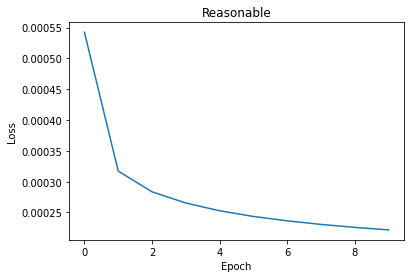

In [9]:
plt.plot(np.arange(len(running_loss_e_Reasonable)), running_loss_e_Reasonable, label='Loss after each epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Reasonable")
plt.savefig("Loss per epoch Reasonable_10_epochs.png")

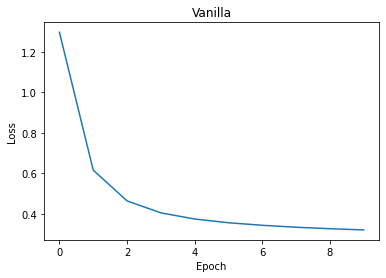

In [10]:
plt.plot(np.arange(len(running_loss_e_VN)), running_loss_e_VN, label='Loss after each epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Vanilla")
plt.savefig("Loss per epoch Vanilla_10_epochs.png")

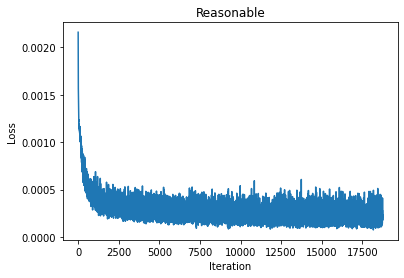

In [11]:
plt.plot(np.arange(len(running_loss_i_Reasonable)), running_loss_i_Reasonable, label='Loss after each iteration')
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title("Reasonable")
plt.savefig("Loss per iteration Reasonable_10_epochs.png")

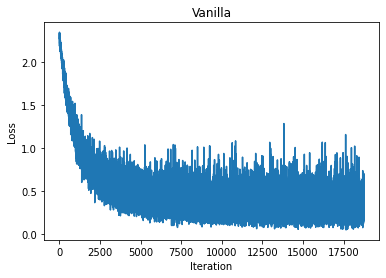

In [12]:
plt.plot(np.arange(len(running_loss_i_VN)), running_loss_i_VN, label='Loss after each iteration')
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title("Vanilla")
plt.savefig("Loss per iteration Vanilla_10_epochs.png")

### 30 epochs

In [26]:
model_VN = VN()
model_VN.to(device)

VN(
  (flat): Flatten()
  (fc1): Linear(in_features=784, out_features=256, bias=False)
  (fc2): Linear(in_features=256, out_features=10, bias=False)
)

In [27]:
model_Reasonable = Reasonable()
model_Reasonable.to(device)

Reasonable(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
)

In [28]:
optimizer_VN = optim.Adam(model_VN.parameters(), lr=1e-5)
criterion_VN = nn.CrossEntropyLoss()
running_loss_i_VN = []
running_loss_e_VN = []

optimizer_Reasonable = optim.Adam(model_Reasonable.parameters(), lr=1e-5)
criterion_Reasonable = nn.MSELoss()
running_loss_i_Reasonable = []
running_loss_e_Reasonable = []

for i in range(30):
    total_loss_VN = 0
    total_loss_Reasonable = 0
    
    for images, labels in trainloader:
        images = images.to(device); labels = labels.to(device)
        
        optimizer_VN.zero_grad()
        outputs_VN = model_VN(images)
        loss_VN = criterion_VN(outputs_VN, labels)
        loss_VN.backward()
        optimizer_VN.step()
        
        running_loss_i_VN.append(loss_VN.item())
        total_loss_VN += loss_VN.item()
        
        labels_Reasonable = []
        for label in labels:
            labels_Reasonable.append(model_VN.get_weights(label))

        labels = torch.stack(labels_Reasonable)
        
        optimizer_Reasonable.zero_grad()
        outputs_Reasonable = model_Reasonable(images)
        loss_Reasonable = criterion_Reasonable(outputs_Reasonable, labels)
        loss_Reasonable.backward()
        optimizer_Reasonable.step()
        
        running_loss_i_Reasonable.append(loss_Reasonable.item())
        total_loss_Reasonable += loss_Reasonable.item()

    running_loss_e_VN.append(total_loss_VN/len(trainloader))
    running_loss_e_Reasonable.append(total_loss_Reasonable/len(trainloader))
    
    print("Epoch {}:".format(i))
    print("    VN loss: {}".format(total_loss_VN/len(trainloader)))
    print("    Reasonable loss: {}\n".format(total_loss_Reasonable/len(trainloader)))

Epoch 0:
    VN loss: 1.297465927441915
    Reasonable loss: 0.0005538699873257429

Epoch 1:
    VN loss: 0.6147496287345886
    Reasonable loss: 0.00032168767330391953

Epoch 2:
    VN loss: 0.4632677806933721
    Reasonable loss: 0.0002888330677524209

Epoch 3:
    VN loss: 0.4040098528146744
    Reasonable loss: 0.00027152408266362425

Epoch 4:
    VN loss: 0.3733727769255638
    Reasonable loss: 0.00025946447709963345

Epoch 5:
    VN loss: 0.35466810432275137
    Reasonable loss: 0.0002500841995778804

Epoch 6:
    VN loss: 0.3417338376243909
    Reasonable loss: 0.0002429043231648393

Epoch 7:
    VN loss: 0.3323696790496508
    Reasonable loss: 0.0002373389026732184

Epoch 8:
    VN loss: 0.32497452901204427
    Reasonable loss: 0.000232631258716962

Epoch 9:
    VN loss: 0.319375199453036
    Reasonable loss: 0.00022868815559583404

Epoch 10:
    VN loss: 0.3145486102382342
    Reasonable loss: 0.00022530889093565445

Epoch 11:
    VN loss: 0.310327297214667
    Reasonable loss

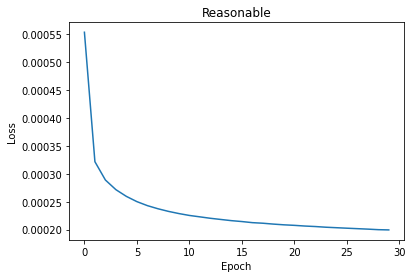

In [29]:
plt.plot(np.arange(len(running_loss_e_Reasonable)), running_loss_e_Reasonable, label='Loss after each epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Reasonable")
plt.savefig('reasonable.jpg')
plt.savefig("Loss per epoch Reasonable_30_epochs.png")

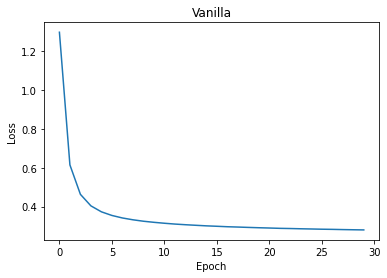

In [30]:
plt.plot(np.arange(len(running_loss_e_VN)), running_loss_e_VN, label='Loss after each epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Vanilla")
plt.savefig('vanilla.jpg')
plt.savefig("Loss per epoch Vanilla_30_epochs.png")

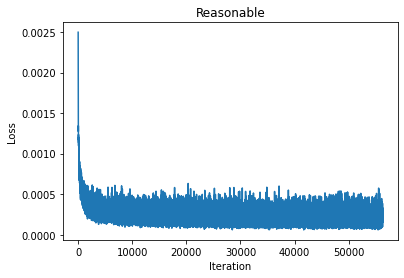

In [31]:
plt.plot(np.arange(len(running_loss_i_Reasonable)), running_loss_i_Reasonable, label='Loss after each iteration')
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title("Reasonable")
plt.savefig("Loss per iteration Reasonable_30_epochs.png")

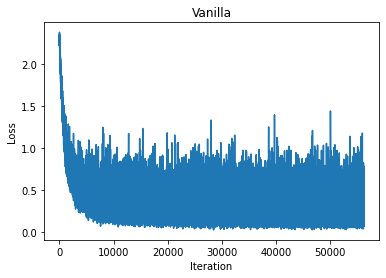

In [32]:
plt.plot(np.arange(len(running_loss_i_VN)), running_loss_i_VN, label='Loss after each iteration')
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title("Vanilla")
plt.savefig("Loss per iteration Vanilla_10_epochs.png")

## UNIT testing

In [33]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
])

trainset = torchvision.datasets.MNIST(root='./data', transform=transform, train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', transform=transform, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [34]:
class ON(nn.Module):
    def __init__(self):
        super(ON, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 2)
        self.conv3 = nn.Conv2d(32, 32, 5, 1)
        self.flat = nn.Flatten()
        self.relu = F.relu
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 11)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

In [35]:
model_ON = ON()
device = torch.device("cuda:0")
model_ON.to(device)

ON(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)

In [36]:
optimizer_ON = optim.Adam(model_ON.parameters(), lr=1e-5)
criterion_ON = nn.CrossEntropyLoss()

running_loss_i_ON = []
running_loss_e_ON = []

In [37]:
for i in range(10):
    total_loss_ON = 0
    
    for images, labels in trainloader:
        images = images.to(device); labels = labels.to(device)
        
        optimizer_ON.zero_grad()
        outputs_ON = model_ON(images)
        loss_ON = criterion_ON(outputs_ON, labels)
        loss_ON.backward()
        optimizer_ON.step()
        
        running_loss_i_ON.append(loss_ON.item())
        total_loss_ON += loss_ON.item()        

    running_loss_e_ON.append(total_loss_ON/len(trainloader))
    
    print("Epoch {} loss: {}".format(i, total_loss_ON/len(trainloader)))

Epoch 0 loss: 1.3936595718383789
Epoch 1 loss: 0.6191124379873276
Epoch 2 loss: 0.23191931735277177
Epoch 3 loss: 0.17267186776399612
Epoch 4 loss: 0.13511137229601541
Epoch 5 loss: 0.11044922784169516
Epoch 6 loss: 0.09341485852797826
Epoch 7 loss: 0.08024376533428827
Epoch 8 loss: 0.07049561092058818
Epoch 9 loss: 0.0618374587615331


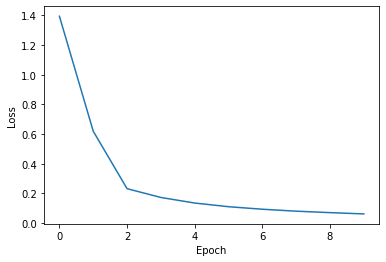

In [38]:
plt.plot(np.arange(len(running_loss_e_ON)), running_loss_e_ON, label='Loss after each epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("Loss per epoch Unit.png")

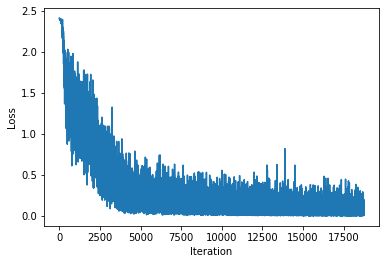

In [39]:
plt.plot(np.arange(len(running_loss_i_ON)), running_loss_i_ON, label='Loss after each iteration')
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.savefig("loss per iter UNIT.png")

In [40]:
inp = torch.rand((1, 1, 28, 28))
inp = inp.to(device)

In [41]:
model_ON.eval()

ON(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)

In [42]:
class TestData(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = []
        for x in range(len(testset)):
            self.dataset.append((torch.rand((1, 28, 28)), 10))
        for x in range(len(testset)):
            self.dataset.append(testset[x])
            
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]
    
ts = TestData()
tsloader = torch.utils.data.DataLoader(ts, batch_size=batch_size)